# GTEx Analysis

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from scipy.stats import fisher_exact
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline

outdir = os.path.join(ciepy.root, 'output',
                      'gtex_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'gtex_analysis')
cpy.makedir(private_outdir)

In [3]:
# This file has the probability of the SNP being a QTL for each tissue
# for the top SNP for that gene. 
fn = ('/publicdata/gtex_20151104/'
      'Multi_tissue_eQTL_GTEx_Pilot_Phase_datasets/'
      'res_final_amean_com_genes_com_snps.txt')
multi_probs = pd.read_table(fn, index_col=0)

# Single tissue results.
fns = glob.glob('/publicdata/gtex_20151104/*.eqtl')
gtex_results = {}
for fn in fns:
    gtex_results[os.path.split(fn)[1].split('.')[0]] = pd.read_table(fn, index_col=0,
                                                                     low_memory=False)
    
# Single tissue expression matrices.
fns = glob.glob('/publicdata/gtex_20151104/*.expr.txt')
gtex_exp = {}
for fn in fns:
    gtex_exp[os.path.split(fn)[1].split('.')[0]] = pd.read_table(fn, index_col=0,
                                                                low_memory=False)

In [4]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
qvalues.columns = ['{}_gene'.format(x) for x in qvalues.columns]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
#encode_chip_seq = pd.read_table(fn, index_col=0)
most_sig = most_sig.join(qvalues)
sig = most_sig[most_sig.sig_gene == 1]

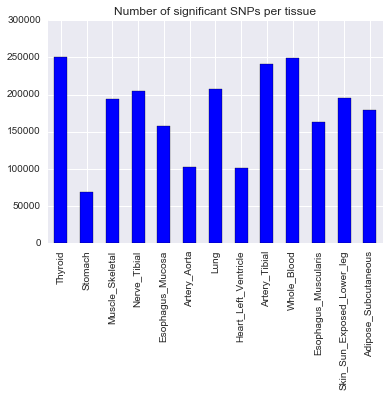

In [5]:
se = pd.Series([df.shape[0] for df in gtex_results.values()], 
               index=gtex_results.keys())
ax = se.plot(kind='bar')
ax.set_title('Number of significant SNPs per tissue');

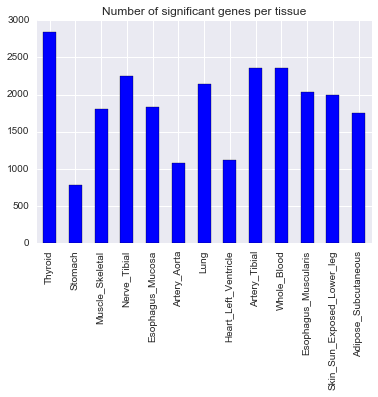

In [6]:
se = pd.Series([len(set(df.Gen_ID)) for df in gtex_results.values()], 
               index=gtex_results.keys())
ax = se.plot(kind='bar')
ax.set_title('Number of significant genes per tissue');

From the supplement: "For a given tissue, genes having at least 0.1 RPKM in 2 or more individuals were retained."
All of the expression matrices only include genes that pass this filter. So I think they tested
all genes in their expression matrices for eQTLs.

I want to see how much my results overlap with theirs. First, I will 
just check for each single tissue how many of our significant genes
overlap. I can compute a $p$-value with a Fisher test.

Then I should test for individual genes to see if our effect is in the
same direction and whether we find similar SNVs.

In [7]:
for k in gtex_exp.keys():
    print(k, gtex_exp[k].shape[0], len(set(gtex_exp[k].index) & set(gene_info.index)))

('Thyroid', 30042, 28604)
('Stomach', 26829, 25433)
('Adipose_Subcutaneous', 27704, 26317)
('Nerve_Tibial', 28891, 27479)
('Esophagus_Mucosa', 26535, 25159)
('Artery_Aorta', 25222, 23890)
('Muscle_Skeletal', 24468, 23198)
('Lung', 30097, 28664)
('Heart_Left_Ventricle', 24116, 22823)
('Artery_Tibial', 26270, 24911)
('Whole_Blood', 25064, 23813)
('Esophagus_Muscularis', 25753, 24404)
('Skin_Sun_Exposed_Lower_leg', 29235, 27817)


In [8]:
pvalues = []
oddsratios = []
for k in gtex_exp.keys():
    edf = gtex_exp[k]
    sdf = gtex_results[k]
    common = set(qvalues.index) & set(edf.index)
    t = qvalues.ix[common]
    edf = edf.ix[common]
    my_sig = set(t[t.sig_gene == 1].index)
    my_not_sig = set(t[t.sig_gene == 0].index)
    gtex_sig = set(sdf.Gen_ID)
    gtex_not_sig = set(edf.index) - gtex_sig
    sig_sig = len(my_sig & gtex_sig)
    sig_not_sig = len(my_sig & gtex_not_sig)
    not_sig_sig = len(my_not_sig & gtex_sig)
    not_sig_not_sig = len(my_not_sig & gtex_not_sig)
    odds, p = fisher_exact([[sig_sig, sig_not_sig], [not_sig_sig, not_sig_not_sig]])
    pvalues.append(p)
    oddsratios.append(odds)
overlap = pd.DataFrame({'pvalue':pvalues, 'odds':oddsratios}, index=gtex_exp.keys())

In [17]:
overlap.pvalue

Thyroid                       1.147519e-159
Stomach                        3.803247e-88
Adipose_Subcutaneous          1.773547e-131
Nerve_Tibial                  1.324723e-143
Esophagus_Mucosa              9.683785e-159
Artery_Aorta                  1.644931e-105
Muscle_Skeletal               3.358277e-115
Lung                          9.730846e-149
Heart_Left_Ventricle          1.810786e-102
Artery_Tibial                 1.674258e-149
Whole_Blood                   2.278305e-100
Esophagus_Muscularis          6.198477e-154
Skin_Sun_Exposed_Lower_leg    3.911499e-134
Name: pvalue, dtype: float64

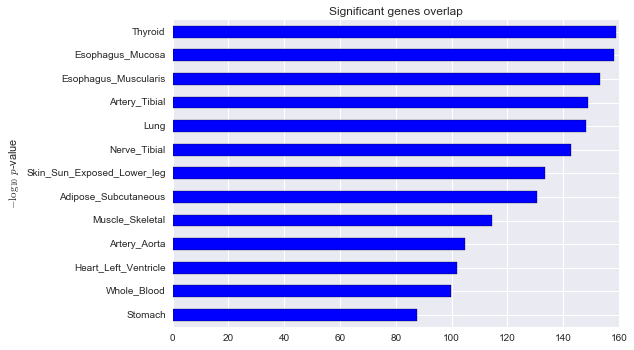

In [22]:
se = -np.log10(overlap.pvalue)
se.sort_values(inplace=True)
se.plot(kind='barh')
plt.ylabel('$-\log_{10}$ $p$-value')
plt.title('Significant genes overlap');

In [10]:
pvalues = []
oddsratios = []
for k in gtex_results.keys():
    res = gtex_results[k]
    # Drop indels and deletions since I haven't looked at those yet.
    res = res.ix[set([x for x in res.index if ((':D' not in x) and (':I' not in x))])]
    res.index = 'chr' + res.SNP_Chr.astype(str) + ':' + res.SNP_Pos.astype(str) + ':' + res.Gen_ID
    gexp = gtex_exp[k]
    # Find genes that were both significant in my study and tested in GTEx.
    common = set(sig.gene) & set(gexp.index)
    common_sig = sig[sig.gene.apply(lambda x: x in common)]
    # Get GTEx results for my most significant SNVs.
    inds = common_sig['loc'] + ':' + common_sig.gene
    out = res.ix[inds, ['P_Val', 'Beta']]
    # Add GTEx results and make some new columns.
    common_sig['gtex_pvalue'] = out.P_Val.values
    common_sig['gtex_beta'] = out.Beta.values
    common_sig['gtex_pvalue_log'] = -np.log10(common_sig.gtex_pvalue)
    common_sig['pvalue_log'] = -np.log10(common_sig.pvalue)
    tdf = common_sig.dropna()
    # Check to see whether beta values agree.
    a = tdf['beta'] > 0
    b = tdf['gtex_beta'] > 0
    ctable = tdf[['beta', 'gtex_beta']].groupby([a,b]).count()['beta'].unstack()
    ctable = ctable.replace(np.nan, 0)
    odds, p = fisher_exact(ctable)
    pvalues.append(p)
    oddsratios.append(odds)
beta_agreement = pd.DataFrame({'pvalue':pvalues, 'odds':oddsratios}, index=gtex_exp.keys())

In [11]:
-np.log10(beta_agreement.pvalue)

Thyroid                              inf
Stomach                       186.862000
Adipose_Subcutaneous          268.275505
Nerve_Tibial                         inf
Esophagus_Mucosa                     inf
Artery_Aorta                  278.136624
Muscle_Skeletal                      inf
Lung                          238.002800
Heart_Left_Ventricle                 inf
Artery_Tibial                 269.046983
Whole_Blood                   321.234333
Esophagus_Muscularis          284.200347
Skin_Sun_Exposed_Lower_leg           inf
Name: pvalue, dtype: float64

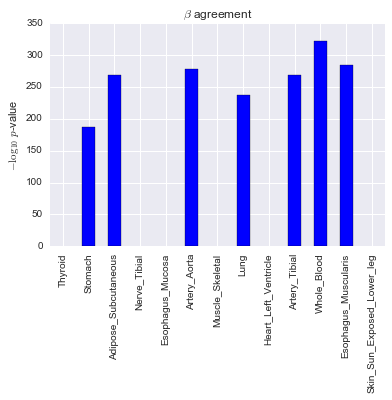

In [12]:
(-np.log10(beta_agreement.pvalue)).plot(kind='bar')
plt.ylabel('$-\log_{10}$ $p$-value')
plt.title(r'$\beta$ agreement');

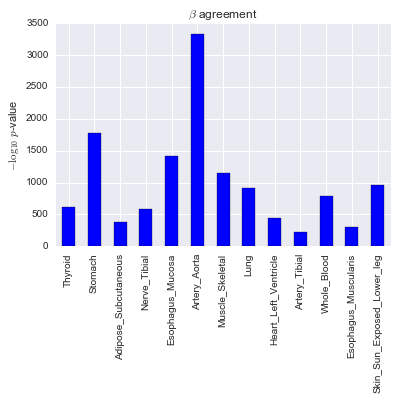

In [13]:
beta_agreement.odds.plot(kind='bar')
plt.ylabel('$-\log_{10}$ $p$-value')
plt.title(r'$\beta$ agreement');

In [14]:
sns.set_context('talk', font_scale=1.2)

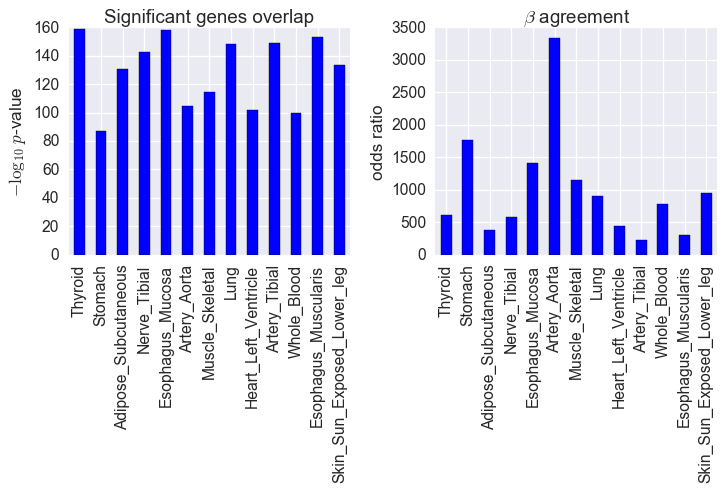

In [15]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
(-np.log10(overlap.pvalue)).plot(kind='bar', ax=ax)
ax.set_ylabel('$-\log_{10}$ $p$-value')
ax.set_title('Significant genes overlap');

ax = axs[1]
beta_agreement.odds.plot(kind='bar', ax=ax)
ax.set_ylabel('odds ratio')
ax.set_title(r'$\beta$ agreement');
plt.tight_layout()
fig.savefig(os.path.join(outdir, 'gtex_comp.pdf'))